In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, M63
from assimilation import OI, M3DVar, ExtendedKF, EnKF, M4DVar, Hybrid3DEnVar
from nmc import nmc

## Basic settings and create nature run

In [10]:
x0 = np.array([[8, 0, 30]]).T
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)

nature = lorenz63_fdm(x0, ts)
nature.shape

(3, 1000)

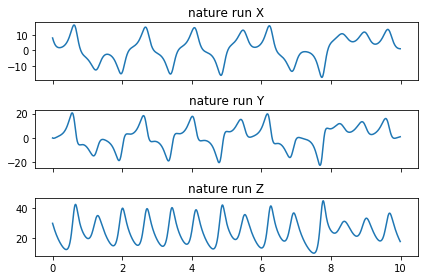

In [82]:
fig, axs = plt.subplots(nrows=3, sharex=True)
for i in range(3):
    axs[i].plot(ts, nature[i,:])

axs[0].set_title('nature run X')
axs[1].set_title('nature run Y')
axs[2].set_title('nature run Z')
plt.tight_layout()

## Background error covariance, observation error covariance, simulated observations

In [66]:
Pb = nmc(lorenz63_fdm, nature, dt, 1, 0.04)
Pb

array([[6.55066443, 6.41875043, 0.90763168],
       [6.41875043, 7.14455189, 0.31749871],
       [0.90763168, 0.31749871, 4.23041534]])

In [68]:
obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]
obs.shape

(3, 125)

In [71]:
R = np.eye(3) * 2
R

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

## Initial condition for assimilation

In [70]:
# a very bad initial condition
X_ini = x0 + np.array([[10, -10, 15]]).T
X_ini

array([[ 18],
       [-10],
       [ 45]])

## Assimilation

In [107]:
def da_rmse(nature, analysis, obs_intv):
    return np.sqrt(np.mean((analysis[:,::obs_intv] - nature[:,::obs_intv]) ** 2, axis=0))

def plot_assimilation_result(nature, obs, analysis, obs_intv):
    fig, axs = plt.subplots(nrows=4, figsize=(8, 8), sharex=True)
    for i in range(3):
        axs[i].plot(ts, nature[i,:], color='#024BC7', label='nature')
        axs[i].plot(ts[::obs_intv], obs[i,:], '.', color='#024BC7', label='obs')
        axs[i].plot(ts, oi.analysis[i,:], color='#FFA500', label='analysis')
    axs[0].legend()
    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    
    rmse = da_rmse(nature, analysis, obs_intv)
    axs[3].plot(ts[::obs_intv], rmse, '.-')
    axs[3].set_title('RMSE')
    
    plt.tight_layout()

#### Optimal interpolation

In [98]:
oi = OI(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3)
}
oi.set_params(**params)
oi.cycle()

Mean RMSE:  0.97095588903785


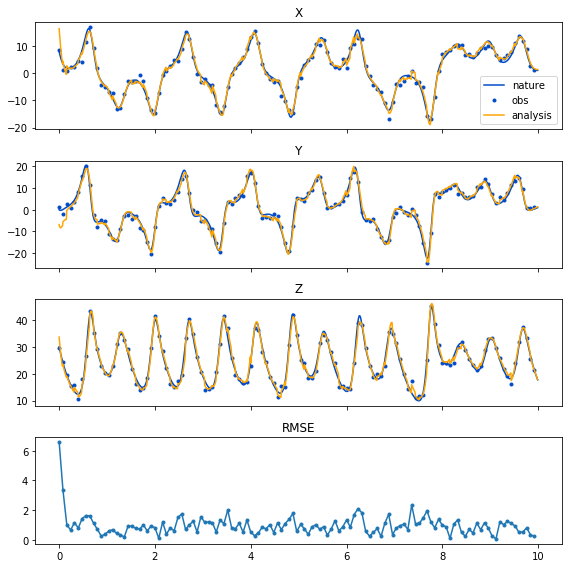

In [110]:
plot_assimilation_result(nature, obs, oi.analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, oi.analysis, obs_intv).mean())

#### 3DVar

In [113]:
tdv = M3DVar(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr
}
tdv.set_params(**params)
tdv.cycle()

Mean RMSE:  0.9709552832419415


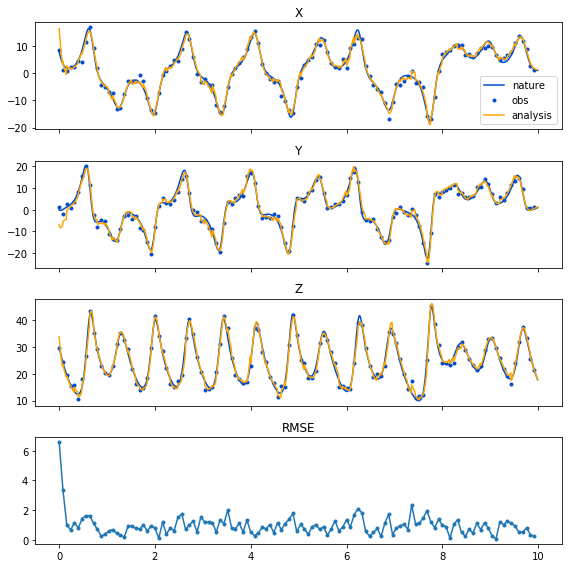

In [114]:
plot_assimilation_result(nature, obs, tdv.analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, tdv.analysis, obs_intv).mean())

#### Extended Kalman Filter

In [126]:
ekf = ExtendedKF(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda x: M63(x, dt),
    'alpha': 0.5,
    'inflat': 1.4
}
ekf.set_params(**params)
ekf.cycle()

Mean RMSE:  0.9637112661604215


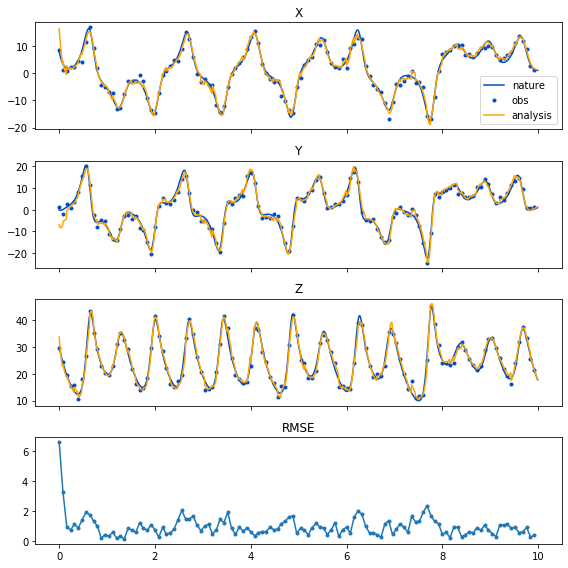

In [127]:
plot_assimilation_result(nature, obs, ekf.analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, ekf.analysis, obs_intv).mean())

#### Ensemble Kalman Filter

In [129]:
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

enkf = EnKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf.set_params(**params)
enkf.cycle()

Mean RMSE:  0.9678091890630778


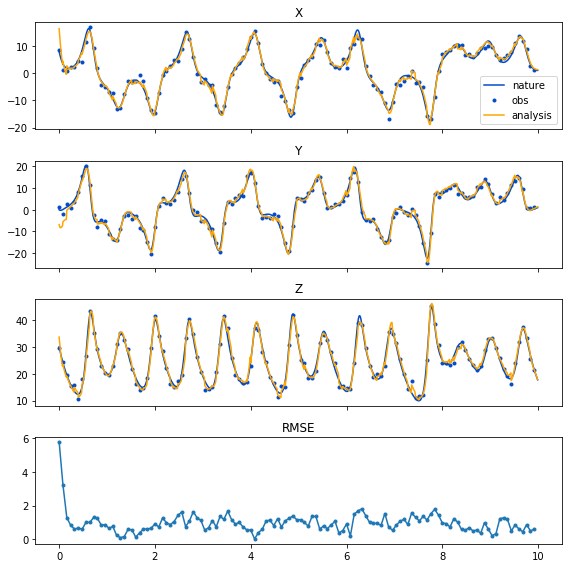

In [130]:
# use ensemble mean
analysis = enkf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

#### Hybrid 3DEnVar

In [132]:
hy3dv = Hybrid3DEnVar(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'alpha': 0.3,
    'inflat': 1.4,
    'beta': 0.7
}
hy3dv.set_params(**params)
hy3dv.cycle()

Mean RMSE:  0.9922195154780662


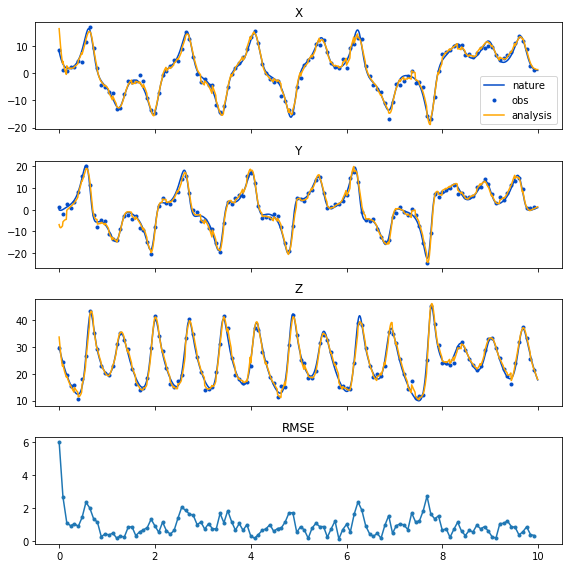

In [134]:
plot_assimilation_result(nature, obs, hy3dv.analysis_3dvar, obs_intv)
print('Mean RMSE: ', da_rmse(nature, hy3dv.analysis_3dvar, obs_intv).mean())

#### 4DVar

In [162]:
# create observations for 4DVar
window_len = 4
forecast_len = 6
window_num = int(nature.shape[1] / (window_len+forecast_len))  # 1000 / 10 = 100

obs_4dv = nature + np.sqrt(2) * np.random.randn(*nature.shape)
for iwin in range(window_num):
    sidx = iwin * (window_len + forecast_len) + window_len
    eidx = sidx + forecast_len
    obs_4dv[:,sidx:eidx] = 0

obs_4dv[:,:20]

array([[ 8.31633452,  8.09863772,  4.91733646,  5.21290472,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.56457271,  3.31192156,  2.73375794,  2.48333778,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.084643  ,  0.95774606,  2.43505151,  0.43249491,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.9898051 ,  0.06116733, -0.34700027, -1.82119304,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [31.38653354, 30.41424693, 30.91865947, 28.99076996,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        21.53163577, 20.2535941 , 19.26344122, 18.38395291,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [163]:
fdv = M4DVar(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'obs': obs_4dv,
    'window_num': window_num,
    'window_len': window_len,
    'forecast_len': forecast_len,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda x: M63(x, dt)
}
fdv.set_params(**params)
fdv.cycle()

Assimilation: [############################################################] 100/100


Mean RMSE:  0.8499577914667471


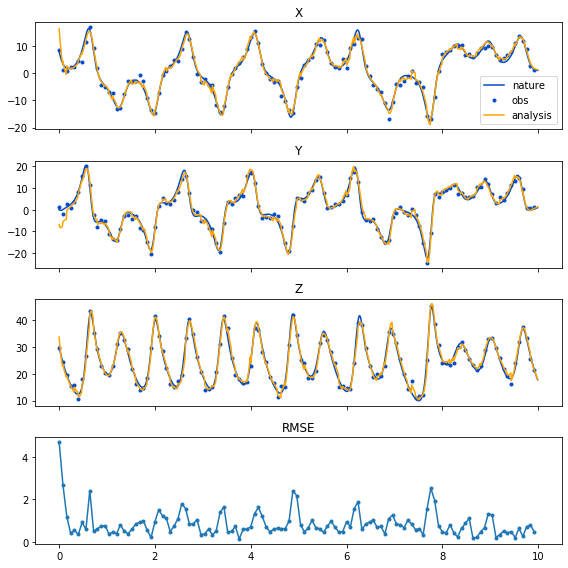

In [164]:
plot_assimilation_result(nature, obs, fdv.analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, fdv.analysis, obs_intv).mean())